## The context
Last weekend I was relaxing in the countryside at a colleague's château, and we decided to take turns shooting at a target with an air rifle.

Unfortunately, we were all terrible shots, and the rifle was uncalibrated, so we didn't do a particularly good job of hitting the target.

To improve our aim, we need to adjust the rifle sights so that the pellet impacts are centred on the middle of the target.


## The model
Let's start modelling this situation in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from PIL import Image
from warnings import filterwarnings
filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [20,20]
np.random.seed(1337)

Let's pretend our rifle is incorrectly sighted/calibrated such that, when we are aiming precisely at the centre of the target, our pellets will land 120 units to the right and 80 pixels down.

Let's also pretend that they will be normally distributed around this point, with a standard deviation of 85 pixels in each axis due to the wind/humidity/our terrible aim. 

This is our generative model, and we use it to generate some fake data. We will later use the same model construct and try and infer the *x_offset* and *y_offset*.

Let's go ahead and randomly generate the results of 5 shots at the target.

In [2]:
x_offset = 120 #units/pixels
y_offset = -80 #units/pixels
standard_deviation = 85 #units/pixels
num_samples = 5 
x_observed = np.random.normal(x_offset,standard_deviation,5)
y_observed = np.random.normal(y_offset,standard_deviation,5)

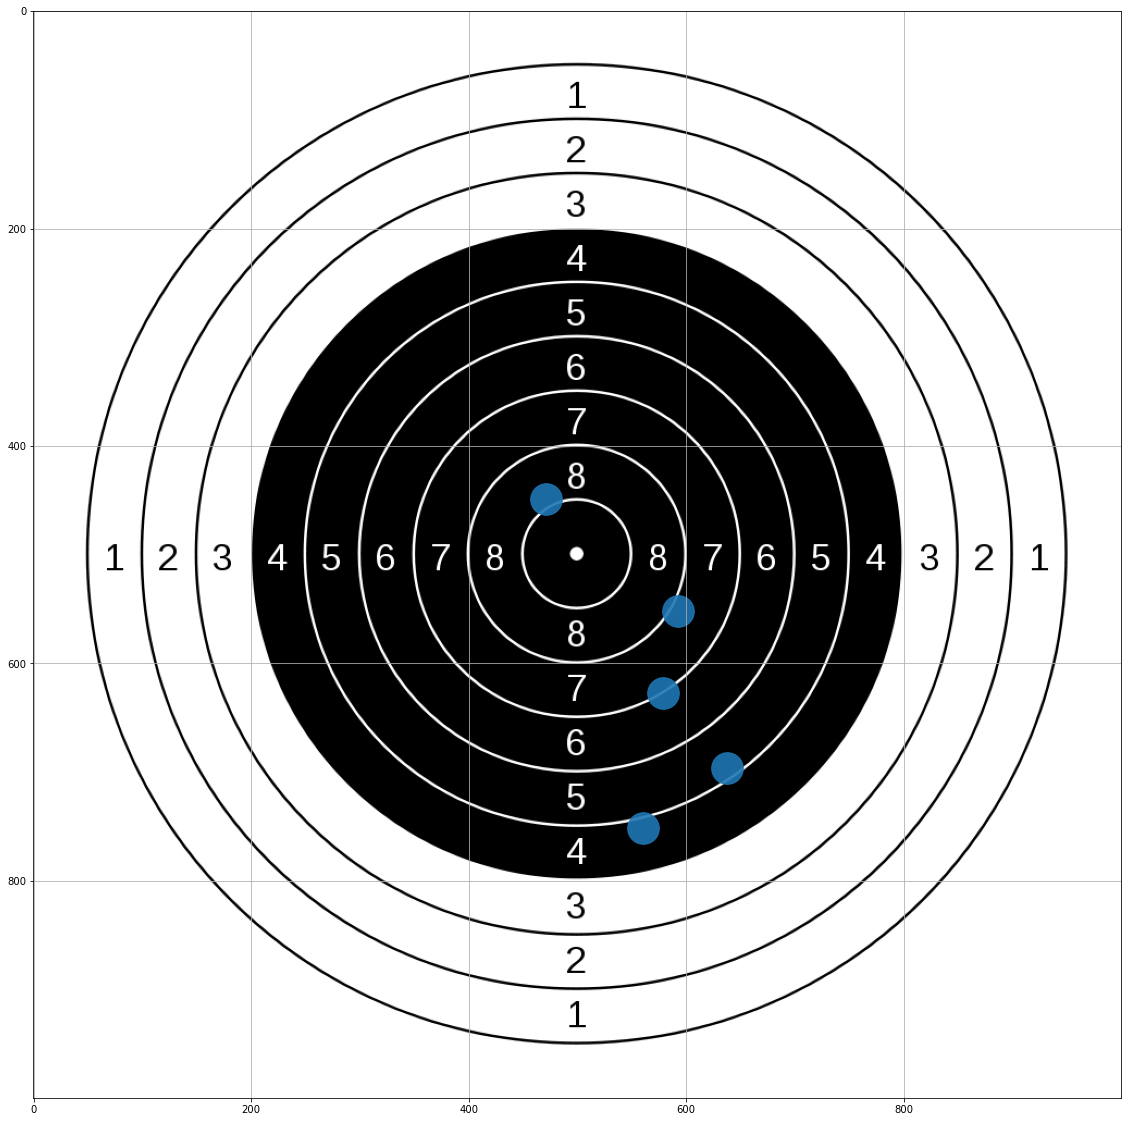

In [3]:
img = Image.open('data/2020-07-02-On-Target-With-PyMC3/1000px-10_m_Air_Rifle_target.svg.png')

plt.imshow(img)
plt.scatter(x_observed+500,500-y_observed,alpha=0.9,s = 1000)

plt.grid()
plt.show()

Now, given we have observed this target. What adjustments should we make to improve our aim?

As part of Bayesian analysis, we need to provide a prior distribution, which tells us what plausible values of *x_offset* and *y_offset* could be. 

Based on the impact locations, PyMC3 will try to infer potential values *x_offset* and *y_offset*, which are the adjustments we need to make to our rifle. 

The beauty of Bayesian analysis is that we don't get a single value as a result but a distribution of values. This allows us to understand how certain we can be about the results.

In [ ]:
with pm.Model() as model: 
    #Set up our model
    x_offset = pm.Normal('x_offset',mu = 0, sigma=250)
    y_offset = pm.Normal('y_offset',mu = 0, sigma=250)
    standard_deviation = pm.HalfNormal('standard_deviation',sigma=200)    
    
    impact_x = pm.Normal('impact_x', mu = x_offset, sigma = standard_deviation, observed = x_observed)
    impact_y = pm.Normal('impact_y', mu = y_offset, sigma = standard_deviation, observed = y_observed)
    
    

Now that we have finished setting up our model, we can use *Markov Chain Monte-Carlo* (MCMC) to infer what *x_offset* and *y_offset* could be. 

In [4]:
with pm.Model() as model: 
    #The magic line that 
    trace = pm.sample(draws=10_000, tune=1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [standard_deviation, y_offset, x_offset]
Sampling 2 chains, 1 divergences: 100%|██████████| 22000/22000 [00:09<00:00, 2309.14draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Results
Now it's time to look at the results; PyMC3 provides several options for understanding them.

Let's start with a numerical summary. From this, we can see the mean value of *x_offset* is 65.6 and *y_offset* is -109.7. Our best guess of where we need to aim is 65.6 units to the left and -109.7 units up.

In [5]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x_offset,65.645,50.662,-36.013,156.687,0.420,0.327,14566.0,12024.0,15361.0,10949.0,1.0
y_offset,-109.744,50.016,-203.327,-13.457,0.475,0.336,11107.0,11107.0,11512.0,9532.0,1.0
standard_deviation,109.028,31.722,59.562,165.361,0.324,0.235,9578.0,9085.0,10639.0,11167.0,1.0


A trace plot is a helpful way to diagnose what is going on. I'm yet to find an excellent tutorial on interpreting it, but here are a few key points that I've picked up.

* Left-Hand Column: Curves should closely overlap. If they don't, then it means that you can't rely on the results. 

* Right-Hand Column: The chart should look like a "Fuzzy Caterpillar". This means that you are effectively exploring the parameter space. 

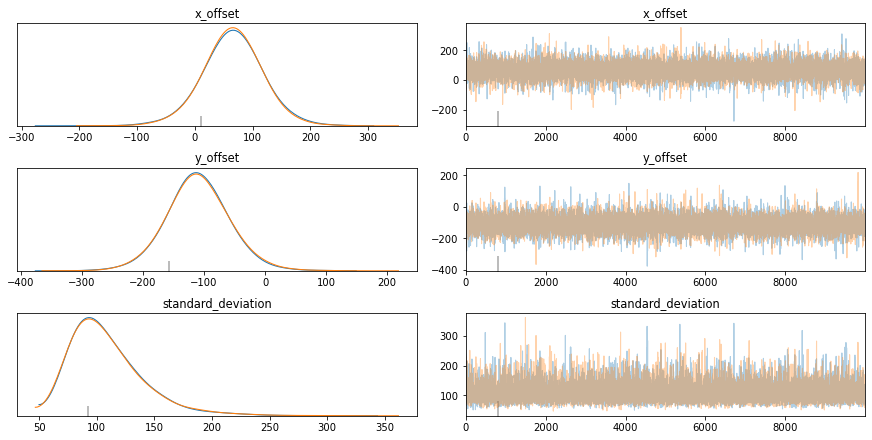

In [6]:
pm.traceplot(trace);

The posterior plot tells you what values your parameters are likely to have. For example, according to our model, there is a 94% chance that x_offset is between -36 and 157. 

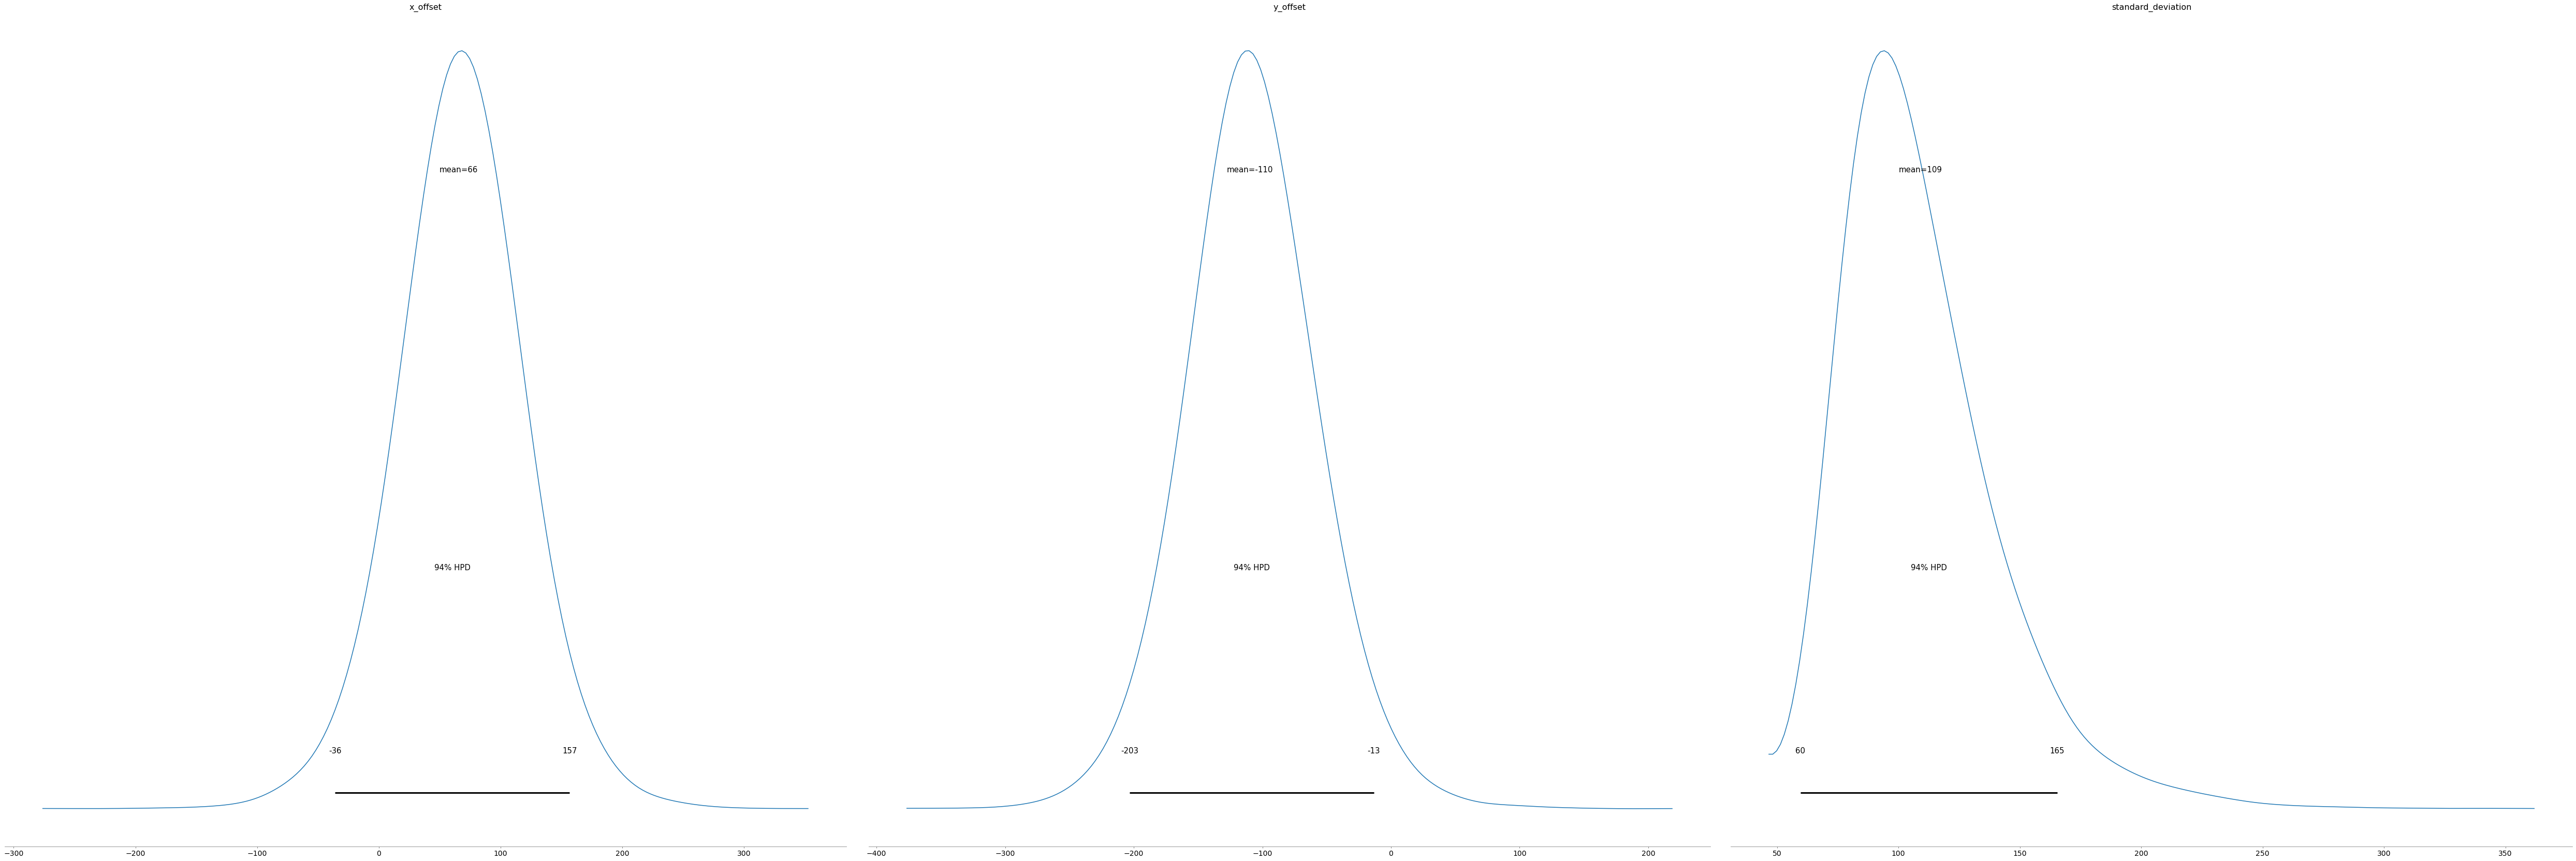

In [7]:
pm.plot_posterior(trace);

Finally, because we have two variables, we can plot them together and understand their joint distribution using Seaborn.

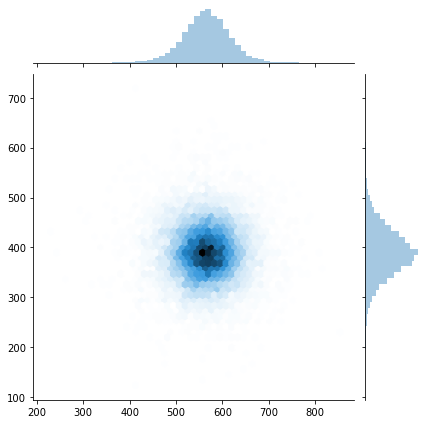

In [10]:
plot = sns.jointplot(trace[:]['x_offset']+500, trace[:]['y_offset']+500, kind="hex");
plt.show()

Putting it all together, we can visualise the potential locations (in red) for the centroid of the actual location of where the pellets will land. With only five samples observed, there is a considerable amount of uncertainty. As the number of samples increases, this uncertainty decreases. 

We can also see that the green point, which marks the actual offset, is within this distribution of potential red locations.

No handles with labels found to put in legend.


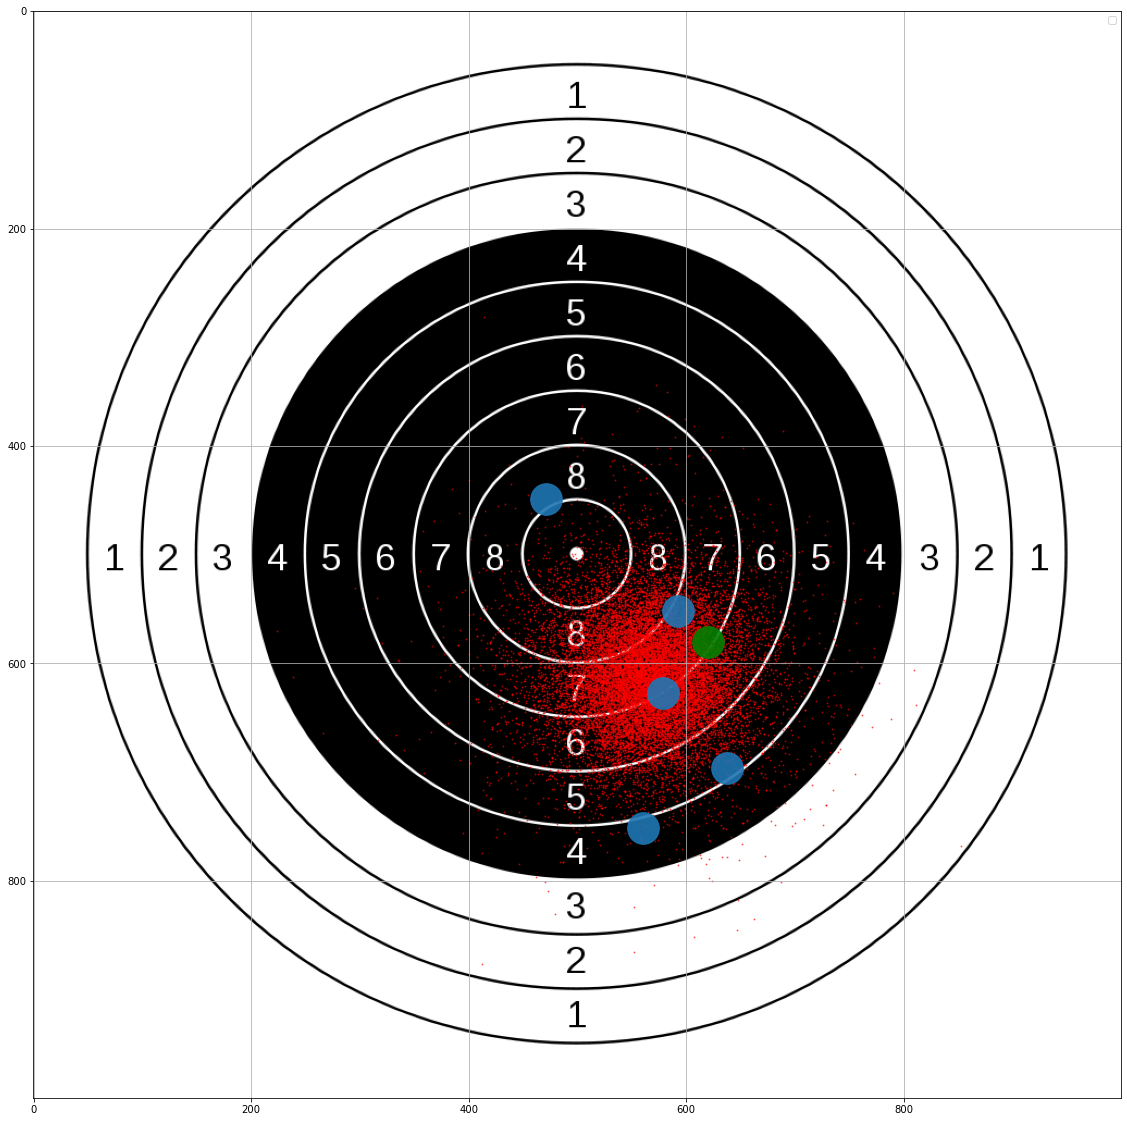

In [12]:
plt.imshow(img)
plt.scatter(trace[:]['x_offset']+500,500-trace[:]['y_offset'],alpha=0.5,s = 1,color='r')
plt.scatter(x_observed+500,500-y_observed,alpha=0.9,s = 1000)
plt.scatter(120+500,500--80,alpha=0.9,s = 1000,color='g')
plt.grid()
plt.show()